# Wine Reviews

In [1]:
import pandas as pd
import numpy as np
import json
import folium
import seaborn as sns
from scipy import stats

In [2]:
df = pd.read_csv("winemag-data-130k-v2.csv", index_col=0)
df = df.dropna(subset=["country", "description", "points", "price"]).reset_index().drop("index", axis=1)
df = df.drop_duplicates("description")
df["country"] = np.where(df["country"] == "US", "United States of America", df["country"])
df

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
1,United States of America,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
2,United States of America,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
3,United States of America,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
4,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120911,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
120912,United States of America,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation
120913,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser
120914,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss


/Users/afnan/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='points'>

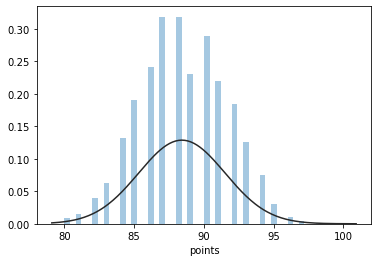

In [3]:
sns.distplot(df['points'], kde=False, fit=stats.norm)

<AxesSubplot:ylabel='Frequency'>

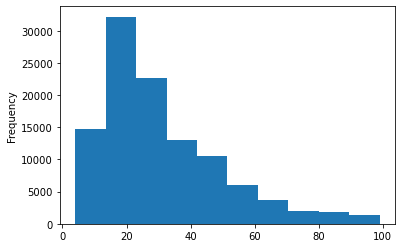

In [4]:
df[df['price'] < 100]['price'].plot.hist()

<AxesSubplot:xlabel='price', ylabel='points'>

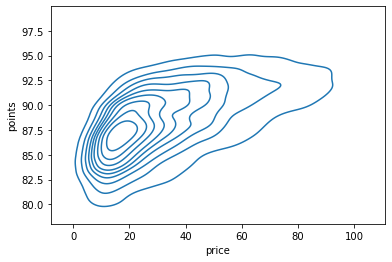

In [5]:
sns.kdeplot(data=df[df['price'] < 100].loc[:, ['price', 'points']].sample(10000), x='price', y='points')

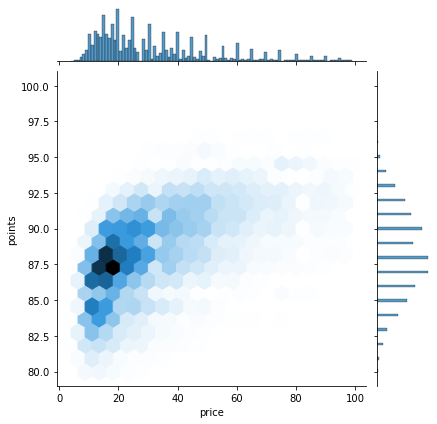

In [6]:
sns.jointplot(x='price', y='points', data=df[df['price'] < 100], kind='hex', gridsize=20)

<AxesSubplot:xlabel='variety', ylabel='points'>

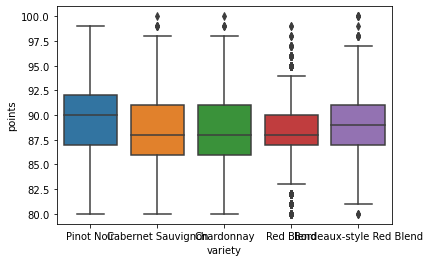

In [7]:
df_top_5 = df[df["variety"].isin(df["variety"].value_counts().head(5).index)]
sns.boxplot(data=df_top_5, x="variety", y="points")

<AxesSubplot:xlabel='points'>

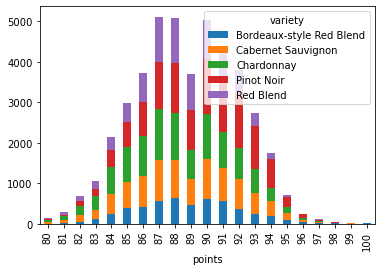

In [8]:
df_top_5[["points", "variety"]].value_counts().unstack().plot.bar(stacked=True)

<AxesSubplot:xlabel='points', ylabel='description_length'>

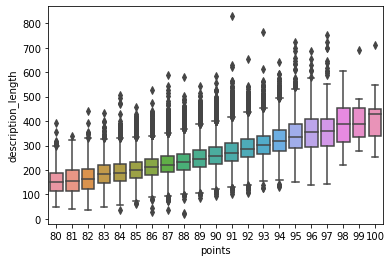

In [9]:
df["description_length"] = df["description"].apply(len)
sns.boxplot(data=df, x="points", y="description_length")

## Map

In [10]:

# JSON cleaning
with open("countries.json") as f:
    raw_countries_json = json.load(f)
countries_json = {"type": "FeatureCollection", "features" : []}
for feature in raw_countries_json["features"]:
    if feature["properties"]["name"] in df["country"].unique():
        countries_json["features"].append(feature)


In [11]:
m = folium.Map(location=[0, 0], zoom_start=2)

folium.Choropleth(
    geo_data=countries_json,
    data=df,
    columns=["country", "price"],
    key_on="feature.properties.name",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    name="Price",
).add_to(m)

folium.LayerControl().add_to(m)

m

# Topic modelling

In [27]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
import pprint

In [28]:
texts = [[word for word in desc.lower().split() if word not in STOPWORDS and word.isalnum() and not word.lower() in ['wine', 'drink']] for desc in list(df["description"].values)]
dictionary = corpora.Dictionary(texts) #(word_id,word) pairs not word.lower() == 'slate'
corpus = [dictionary.doc2bow(text) for text in texts] #(word_id,freq) pairs by sentence

In [29]:
num_topics = 10 #The number of topics that should be generated
passes = 10
lda = LdaModel(corpus, id2word=dictionary, num_topics=num_topics, passes=passes)

In [30]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(lda.print_topics(num_words=10))

[   (   0,
        '0.037*"black" + 0.030*"fruit" + 0.028*"aromas" + 0.027*"flavors" + '
        '0.020*"dark" + 0.019*"notes" + 0.018*"cherry" + 0.016*"tannins" + '
        '0.013*"dried" + 0.013*"palate"'),
    (   1,
        '0.044*"flavors" + 0.038*"pinot" + 0.036*"like" + 0.028*"sweet" + '
        '0.021*"cherry" + 0.019*"good" + 0.019*"little" + 0.018*"dry" + '
        '0.013*"rich" + 0.012*"soft"'),
    (   2,
        '0.013*"quality" + 0.012*"expression" + 0.011*"natural" + '
        '0.010*"backed" + 0.010*"highlights" + 0.010*"shows" + 0.009*"soften" '
        '+ 0.009*"intensity" + 0.009*"tones" + 0.009*"late"'),
    (   3,
        '0.043*"aromas" + 0.043*"palate" + 0.029*"black" + 0.028*"offers" + '
        '0.023*"alongside" + 0.022*"red" + 0.019*"opens" + 0.019*"tannins" + '
        '0.016*"delivers" + 0.015*"spice"'),
    (   4,
        '0.026*"years" + 0.023*"new" + 0.022*"time" + 0.017*"french" + '
        '0.016*"bottle" + 0.016*"aged" + 0.015*"wines" + 0.015*"powerfu

In [26]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

lda_display = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(lda_display)

/Users/afnan/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/afnan/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/afnan/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/afnan/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/afnan/opt/anaconda3/lib/python3.9/

# Clustering with NLP and kMeans

In [16]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

['Portuguese Red' 'Riesling' 'Pinot Noir' 'Cabernet Sauvignon'
 'Chardonnay' 'Malbec' 'Red Blend' 'White Blend' 'Merlot'
 'Sauvignon Blanc' 'Sangiovese' 'Bordeaux-style Red Blend' 'Rosé'
 'Zinfandel' 'Syrah' 'Nebbiolo' 'Sparkling Blend' 'Tempranillo']


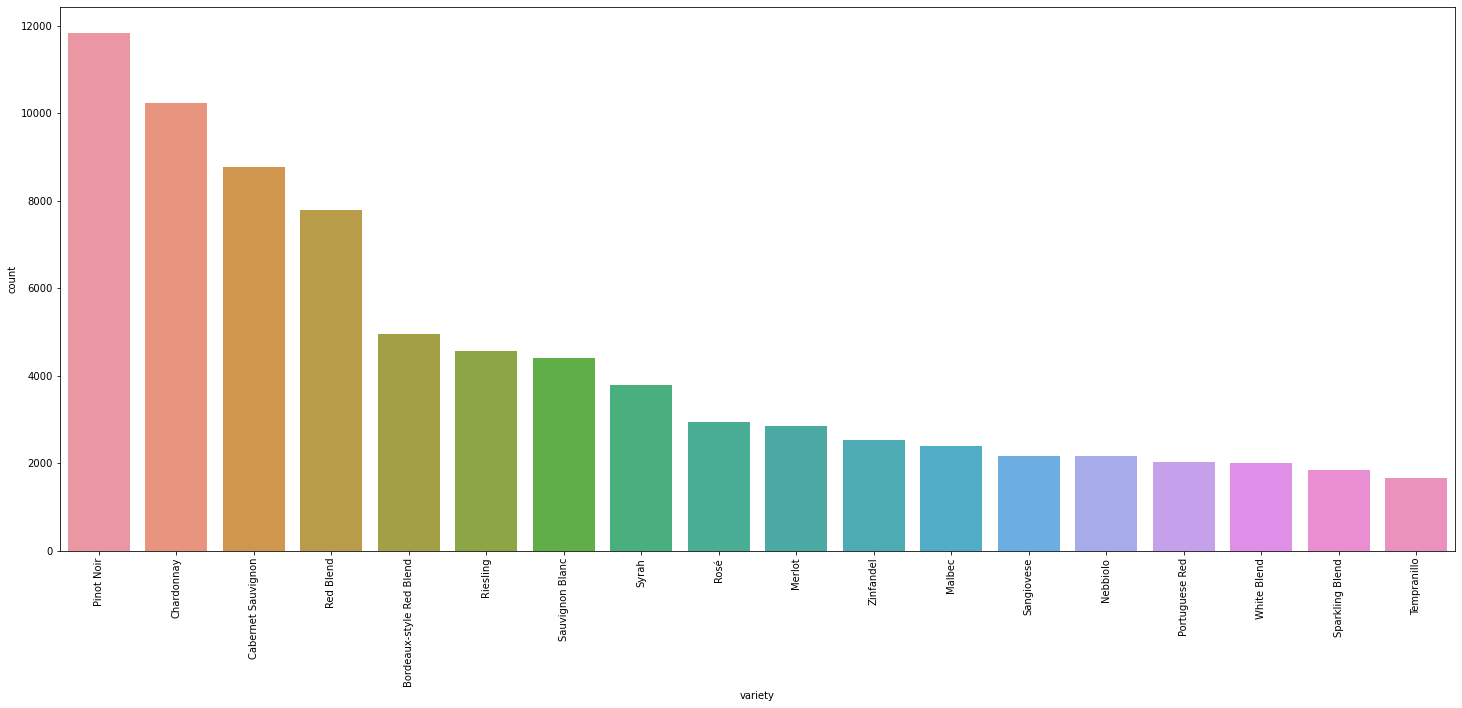

In [17]:
variety_df = df.groupby('variety').filter(lambda x: len(x) > 1500)
print(variety_df['variety'].unique())
varieties = variety_df['variety'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (25, 10))
sns.countplot(x = variety_df['variety'], order = varieties, ax = ax)
plt.xticks(rotation = 90)
plt.show()

In [18]:
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
desc = variety_df['description'].values
vectorizer = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 1000)
X = vectorizer.fit_transform(desc)
words = vectorizer.get_feature_names_out()

/Users/afnan/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


In [19]:
kmeans = KMeans(n_clusters = len(variety_df['variety'].unique()))
kmeans.fit(X)

KMeans(n_clusters=18)

In [20]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : berri, plum, aroma, finish, flavor, herbal, feel, palat, note, oak
1 : chardonnay, pineappl, butter, flavor, toast, vanilla, oak, tropic, acid, rich
2 : black, cherri, fruit, flavor, wine, tannin, dark, pepper, aroma, finish
3 : riesl, dri, lime, peach, lemon, finish, miner, honey, acid, tangerin
4 : wood, age, wine, fruit, drink, rich, ripe, tannin, structur, acid
5 : bodi, medium, wine, flavor, textur, finish, aroma, light, cherri, fruit
6 : blackberri, currant, flavor, dri, tannin, rich, cabernet, cherri, oak, wine
7 : wine, structur, fruit, tannin, age, firm, rich, drink, dens, ripe
8 : new, oak, french, age, month, barrel, fruit, wine, flavor, ferment
9 : fruiti, wine, readi, drink, soft, attract, acid, fruit, ripe, red
10 : crisp, wine, acid, textur, fresh, fruiti, fruit, drink, miner, light
11 : palat, tannin, alongsid, cherri, aroma, black, offer, berri, red, spice
12 : appl, lemon, citrus, palat, finish, flavor, fresh, white, aroma, lime
13 : pinot, noir, cherri, raspberri

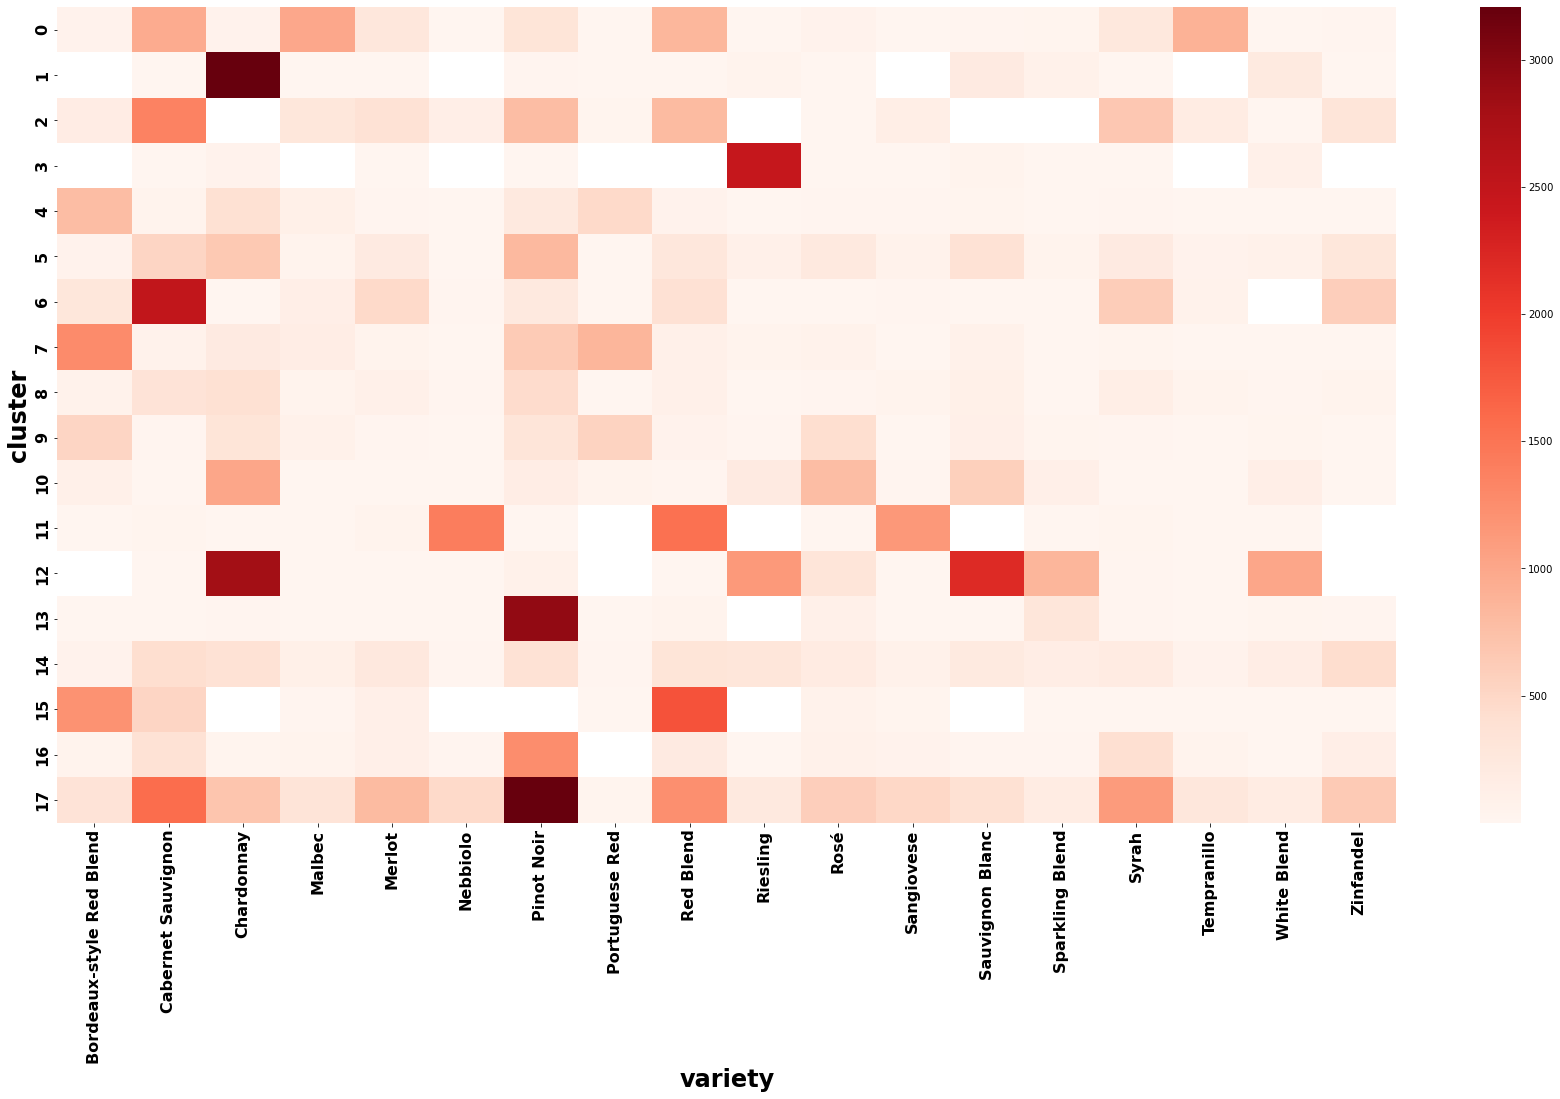

In [21]:
variety_df['cluster'] = kmeans.labels_
clusters = variety_df.groupby(['cluster', 'variety']).size()
fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'variety'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('variety', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

# Recommendation system

In [22]:
from sklearn.neighbors import NearestNeighbors # KNN Clustering 
from scipy.sparse import csr_matrix # Compressed Sparse Row matrix
from sklearn.decomposition import TruncatedSVD # Dimensional Reduction

In [23]:
col = ['province','variety','points']

wine1 = df[col]
wine1 = wine1.dropna(axis=0)
wine1 = wine1.drop_duplicates(['province','variety'])
wine1 = wine1[wine1['points'] > 85]

wine_pivot = wine1.pivot(index= 'variety',columns='province',values='points').fillna(0)
wine_pivot_matrix = csr_matrix(wine_pivot)

In [24]:
knn = NearestNeighbors(n_neighbors=10, algorithm= 'brute', metric= 'cosine')
model_knn = knn.fit(wine_pivot_matrix)

In [31]:
for n in range(3):
    query_index = np.random.choice(wine_pivot.shape[0])
    #print(n, query_index)
    distance, indice = model_knn.kneighbors(wine_pivot.iloc[query_index,:].values.reshape(1,-1), n_neighbors=6)
    for i in range(0, len(distance.flatten())):
        if  i == 0:
            print('Recommendation for ## {0} ##:'.format(wine_pivot.index[query_index]))
        else:
            print('{0}: {1} with distance: {2}'.format(i,wine_pivot.index[indice.flatten()[i]],distance.flatten()[i]))
    print('\n')

Recommendation for ## Kisi ##:
1: Mtsvane with distance: 6.605237960899402e-05
2: Saperavi with distance: 0.17582544813162082
3: Other with distance: 0.2928932188134524
4: Chinuri with distance: 0.2928932188134524
5: Rkatsiteli with distance: 0.2969453073419229


Recommendation for ## Sauvignon ##:
1: Pinot Nero with distance: 0.5696763657308841
2: Marzemino with distance: 0.6294932047909475
3: Tocai with distance: 0.6295400961258149
4: Corvina with distance: 0.6295804242862728
5: Friulano with distance: 0.6295810859448427


Recommendation for ## Abouriou ##:
1: Loin de l'Oeil with distance: 0.0
2: Gros and Petit Manseng with distance: 0.0
3: Tannat-Cabernet with distance: 0.0
4: Abouriou with distance: 0.0
5: Petit Courbu with distance: 0.0


